# KERNEL LENNEL WEEK 1 CS 421 PROJECT
---

### 1. Background & Objective

In this project, you will be working with data extracted from famous recommender systems type datasets: you are provided with a large set of interactions between users (persons) and items (movies). Whenever a user "interacts" with an item, it watches the movie and gives a "rating". There are 5 possible ratings expressed as a "number of stars": 1,2,3,4, or 5.

In this exercise, we will **not** be performing the recommendation task per se. Instead, you will try to identify the amount of noise/corruption which was injected in each user. Indeed, for each of the users you have been given, an anomaly/noise generation procedure was applied to corrupt the sample. The noise generation procedure depends on two variables: the noise level $p\in [0,1]$ and the noise type $X\in\{0,1,2\}$.  Each user has been randomly assigned a noise level $p$ and anomaly/noise type $X$, and subsequently been corrupted with the associated noise generation procedure.

You have two tasks: first, you must predict the noise level $p$ associated to each test user. This is a **supervised regression task**. Second, you must try to identify the noise generation type for each user. This is a classification task with three classes, with the possibility of including more classes later depending on class performance. This task will be semi-supervised: only a very small number of labels is provided. You will therefore need to combine supervised and unsupervised approaches for this component.

### 2. Data

You are provided with three frames: the first one ("X") contains the interactions provided to you, and the second one ("yy") contains the continuous for the users. The third data frame "yy_cat" contains the anomaly/noise type for 15 users. The idea is to use these users to disambiguate the category types, but the task will mostly be unsupervised.

As you can see, the three columns in "X" correspond to the user ID, the item ID and the rating (encoded into numerical form). Thus, each row of "X" contains a single interaction. For instance, if the row "$142, 152, 5$" is present, this means that the user with ID $142$ has given the movie $152$ a positive rating of $5$.

The dataframe "yy" has two columns. In the first column we have the user IDs, whilst the second column contains the continuous label. A label of $0.01$ indicates a very low anomaly level, whilst a label of $0.99$ indicates a very high amount of noise/corruption.

### 3. Evaluation

Your task is to be able to regress the noise level $p$ for each new user, and predict the anomaly type $X$. The first (regression) task will be easier due to the larger amount of supervision, and will form the main basis of the evaluation. The second task will be more importance to showcase each team's creativity and differentiate between top performers.

THE **EVALUATION METRICs** are:  

1. The Mean Absolute Error (MAE) for the regression task.
2. The accuracy for the classiciation task.

Every few weeks, we will evaluate the performance of each team (on a *test set with unseen labels* that I will provide) in terms of both metrics

The difficulty implied by **the generation procedure of the anomalies MAY CHANGE as the project evolves: depending on how well the teams are doing, I may generate easier or harder anomaly classes, which would change the number of labels in the classification task**. However, the regression task will still be the same (with a different distribution).

### 4. Deliverables

Together with this file, you are provided with a first batch of examples "`first_batch_regression_labelled.npz`" which are labelled in terms of noise level. You are also provided with the test samples to rank by the next round (without labels) in the file "`second_batch_regression_unlabelled.npz`".

The **first round** will take place after recess (week 9): you must hand in your scores for the second batch before the **Wednesday at NOON (15th of October)**. We will then look at the results together on the Friday.  

We will check everyone's performance in this way every week (once on  week 10, once on week 11 and once on week 12).

---

To summarise, the project deliverables are as follows:

- Before every checkpoint's deadline, you need to submit **a `.csv` file** containing a dataframe of size $\text{number of test batch users} \times 3$.
    - The first column should be the user IDs of the test batch.
    - The second column should contain the estimated noise level $p$ for each sample.
    - The final column should contain the estimated class (it should be a natural number in \{0,1,2\}).
- The order of rows should correspond to the user IDs. For example, if the test batch contains users 1100-2200, scores for user 1100 should be the first row (row 0), scores for user 1101 should be the second row (row 1), and so on.
- On Week 12-13 (schedule to be decided), you need to present your work in class. The presentation duration is **10 minutes** with 5 minutes of QA.
- On Week 12, you need to submit your **Jupyter Notebook** (with comments in Markdown) and the **slides** for your presentation.
- On week 13 you need to submit your **final report**. The final report should be 2-3 pages long (consisting of problem statement, literature review, and motivation of algorithm design) with unlimited references/appendix.

Whilst performance (expressed in terms of MAE and accuracy) at **each of the check points** (weeks 9 to 12 inclusive) is an **important component** of your **final grade**, the **final report** and the detail of the various methods you will have tried will **also** be very **important**. Ideally, to get perfect marks (A+), you should try at least **two supervised methods** and **two unsupervised methods**, as well as be ranked the **best team** in terms of performance.


In addition, I will be especially interested in your **reasoning**. Especially high marks will be awarded to any team that is able to **qualitatively describe** the difference between the two anomaly types. You are also encouraged to compute statistics related to each class and describe what is different about them.

# Data Loading

In [1]:
# install scikeras
!pip install scikeras
!pip install --upgrade scikit-learn
!pip install --upgrade scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 92.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import skew

data  = np.load("first_batch_regression_labelled.npz")
X     = data["X"]
y     = data["yy"]
y_cat = data["yy_cat"]

# Load dataframes
X     = pd.DataFrame(X, columns=["user", "item", "rating"])
y     = pd.DataFrame(y, columns=["user", "label"])
y_cat = pd.DataFrame(y_cat, columns=["user", "label", "anomtype"])

# Parse to correct types
y     = y.astype({"user": int, "label": float})
y_cat = y_cat.astype({"user": int, "label": float, "anomtype": int})

XX    = np.load("second_batch_regression_unlabelled.npz")['X']
XX    = pd.DataFrame(XX, columns=["user", "item", "rating"])

**Understanding the dataset**

In [3]:
# @title
# Count unique users
unique_users_1 = X["user"].nunique()
unique_users_2 = XX["user"].nunique()

print(f"Number of unique users in first batch: {unique_users_1}")
print(f"Number of unique users in second batch: {unique_users_2}")


# Count unique movies
unique_movies_1 = X["item"].nunique()
unique_movies_2 = XX["item"].nunique()

print(f"Number of unique movies in first batch: {unique_movies_1}")
print(f"Number of unique movies in second batch: {unique_movies_2}")

Number of unique users in first batch: 900
Number of unique users in second batch: 900
Number of unique movies in first batch: 1000
Number of unique movies in second batch: 1000


900 users in both first and second batch

---


1000 movies in both first and second batch

Number of samples

In [4]:
# @title
print(len(X))
print(len(XX))
print(len(y))

288205
282446
900


Viewing Dataset

In [5]:
# @title
print(X.head(1000))

     user  item  rating
0       0    94       2
1       0    90       1
2       0    97       2
3       0   100       4
4       0   101       2
..    ...   ...     ...
995     3   282       5
996     3    70       5
997     3   466       4
998     3   464       5
999     3   461       5

[1000 rows x 3 columns]


In [6]:
# @title
print(XX.head(1000))

     user  item  rating
0     900     0       2
1     900   388       2
2     900   389       3
3     900   390       0
4     900   401       5
..    ...   ...     ...
995   903   724       5
996   903   266       3
997   903   219       3
998   903   299       5
999   903   773       4

[1000 rows x 3 columns]


In [7]:
# @title
print(y.head())

   user     label
0     0  0.962817
1     1  0.031248
2     2  0.068668
3     3  0.349012
4     4  0.917704


In [8]:
# @title
print(y_cat)

    user     label  anomtype
0    561  0.383316         1
1    202  0.925028         2
2    205  0.380860         2
3    424  0.255181         1
4    284  0.055162         2
5    667  0.558745         0
6    730  0.311928         1
7    469  0.233492         2
8    199  0.165112         1
9    699  0.261752         2
10   231  0.951103         0
11    26  0.558222         0
12   786  0.549116         0
13   849  0.301816         1
14   459  0.739300         0


No. of ratings per user

In [9]:
# @title
X["user"].value_counts()

,count
user,
125,918
290,764
764,761
452,752
307,752
...,...
192,200
153,200
477,200


No. of ratings per movie

In [10]:
# @title
X["item"].value_counts()

,count
item,
404,610
425,590
240,586
51,581
94,576
...,...
990,129
53,128
842,124


Check if there are duplicates for any user, movie pair rating

In [11]:
# @title
user_df = X[X["user"] == 816].copy()

# Items user rated more than once (regardless of rating value)
multi = (user_df.groupby("item")
         .agg(n_ratings=("rating", "size"),
              unique_ratings=("rating", "nunique"),
              ratings=("rating", lambda s: list(s)))
         .reset_index())

# 1) All duplicated (user,item)
dupe_items = multi.loc[multi["n_ratings"] > 1, "item"]
dupe_rows = user_df[user_df["item"].isin(dupe_items)].sort_values(["item", "rating"])
print("All repeated (user,item) rows for user:")
print(dupe_rows)


All repeated (user,item) rows for user:
        user  item  rating
262139   816    24       4
262223   816    24       4
262319   816    24       5
262233   816    34       4
262250   816    34       4
...      ...   ...     ...
262394   816   996       5
262398   816   996       5
262439   816   999       4
262242   816   999       5
262464   816   999       5

[224 rows x 3 columns]


Confirmed that some users have duplicate ratings for the same item. But not all users have duplicate ratings (eg user 1 doesnt, but user 3 has)

In [12]:
# @title
from sklearn.model_selection import train_test_split

# Split users (each row is unique)
y_train, y_temp = train_test_split(y, test_size=0.2, random_state=88)
y_val, y_test = train_test_split(y_temp, test_size=0.5, random_state=88)

# Then subset X by these users
train_subset = X[X['user'].isin(y_train['user'])]
val_subset   = X[X['user'].isin(y_val['user'])]
test_subset  = X[X['user'].isin(y_test['user'])]




# Regression

creating features for data

In [13]:
import pandas as pd
import numpy as np
from scipy import stats

def create_comprehensive_features(df):
    """
    Create comprehensive statistical features for ratings.

    Features created:
    - Global z-score for all ratings
    - Per user features: mean, std, z-score, skew, min, max, count
    - Per item features: mean, std, z-score, skew, min, max, count

    Parameters:
    df : DataFrame with columns ['user', 'item', 'rating']

    Returns:
    DataFrame with original columns plus all engineered features
    """

    df = df.copy()

    # ============ Global Z-Score ============
    df['global_zscore'] = stats.zscore(df['rating'], nan_policy='omit')

    # ============ Per User Features ============
    user_stats = df.groupby('user')['rating'].agg([
        ('user_mean', 'mean'),
        ('user_std', 'std'),
        ('user_skew', lambda x: stats.skew(x)),
        ('user_min', 'min'),
        ('user_max', 'max'),
        ('user_count', 'count')
    ]).reset_index()

    # Calculate user z-score
    user_zscore = df.groupby('user')['rating'].apply(
        lambda x: pd.Series(stats.zscore(x, nan_policy='omit'), index=x.index)
    ).reset_index(level=0, drop=True).to_frame(name='user_zscore')

    df = df.merge(user_stats, on='user', how='left')
    df = df.merge(user_zscore, left_index=True, right_index=True, how='left')

    # ============ Per Item Features ============
    item_stats = df.groupby('item')['rating'].agg([
        ('item_mean', 'mean'),
        ('item_std', 'std'),
        ('item_skew', lambda x: stats.skew(x)),
        ('item_min', 'min'),
        ('item_max', 'max'),
        ('item_count', 'count')
    ]).reset_index()

    # Calculate item z-score
    item_zscore = df.groupby('item')['rating'].apply(
        lambda x: pd.Series(stats.zscore(x, nan_policy='omit'), index=x.index)
    ).reset_index(level=0, drop=True).to_frame(name='item_zscore')

    df = df.merge(item_stats, on='item', how='left')
    df = df.merge(item_zscore, left_index=True, right_index=True, how='left')

    # ============ Smart NaN Filling ============
    # Fill std with 0 (no variability when only 1 rating)
    df['user_std'] = df['user_std'].fillna(0)
    df['item_std'] = df['item_std'].fillna(0)

    # Fill skewness with global skewness
    global_skew = stats.skew(df['rating'])
    df['user_skew'] = df['user_skew'].fillna(global_skew)
    df['item_skew'] = df['item_skew'].fillna(global_skew)

    # Fill z-scores with global z-score
    df['user_zscore'] = df['user_zscore'].fillna(df['global_zscore'])
    df['item_zscore'] = df['item_zscore'].fillna(df['global_zscore'])

    # Fill any remaining NaN with 0
    df = df.fillna(0)

    return df


X_features = create_comprehensive_features(X)

# Features that need both mean AND std aggregation
features_with_std = [
    'global_zscore', 'user_zscore', 'item_mean', 'item_std', 'item_zscore',
    'item_skew', 'item_min', 'item_max', 'item_count'
]

# All other numeric features (will be aggregated by mean only)
all_features = X_features.select_dtypes(include=['number']).columns.tolist()
features_mean_only = [f for f in all_features if f not in features_with_std]

# Build aggregation dictionary
agg_dict = {}

# Features aggregated by mean only
for feat in features_mean_only:
    agg_dict[feat] = 'mean'

# Features aggregated by both mean and std
for feat in features_with_std:
    agg_dict[feat] = ['mean', 'std']

# Group by user
X_grouped = X_features.groupby('user').agg(agg_dict).reset_index()

# Flatten column names for easier access
X_grouped.columns = ['_'.join(col).strip('_') if col[1] else col[0]
                     for col in X_grouped.columns.values]

combined = X_grouped.merge(y, on='user', how='left').drop(['user_mean', 'item_mean', 'rating_mean'], axis=1)
combined.columns

Index(['user', 'user_mean_mean', 'user_std_mean', 'user_skew_mean',
       'user_min_mean', 'user_max_mean', 'user_count_mean',
       'global_zscore_mean', 'global_zscore_std', 'user_zscore_mean',
       'user_zscore_std', 'item_mean_mean', 'item_mean_std', 'item_std_mean',
       'item_std_std', 'item_zscore_mean', 'item_zscore_std', 'item_skew_mean',
       'item_skew_std', 'item_min_mean', 'item_min_std', 'item_max_mean',
       'item_max_std', 'item_count_mean', 'item_count_std', 'label'],
      dtype='object')

Split into train, test 80:20 ratio

In [14]:
X_combined = combined.drop(['user', 'label'], axis=1)
y_combined = combined['label']

X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_combined,
    test_size=0.2,
    random_state=42
)

print("="*70)
print("Train-Test Split (80:20)")
print("="*70)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"\nTrain set: {len(X_train) / len(X_combined) * 100:.1f}%")
print(f"Test set: {len(X_test) / len(X_combined) * 100:.1f}%")

Train-Test Split (80:20)
X_train shape: (720, 24)
X_test shape: (180, 24)
y_train shape: (720,)
y_test shape: (180,)

Train set: 80.0%
Test set: 20.0%


PCA

Eigenvectors for each PC: 
[[-2.77474218e-01  1.98351772e-01  1.89943570e-01 -9.29940309e-02
  -6.96323060e-02 -2.30353860e-02 -2.77474218e-01  1.98351772e-01
   8.95515356e-03  2.37049601e-02 -2.88947916e-01 -1.19229675e-01
   2.90864630e-01 -2.80945436e-01 -2.16512322e-01  2.17206003e-01
   2.89487421e-01 -1.83722522e-01 -2.59583892e-01 -2.55883132e-01
  -0.00000000e+00 -0.00000000e+00  1.93383390e-01  2.71057466e-01]
 [-1.41914646e-01  3.03465455e-01 -1.82034113e-02 -3.13028504e-01
   5.16545204e-02  3.42954536e-01 -1.41914646e-01  3.03465455e-01
  -5.71351313e-03 -3.33263196e-01  5.67772795e-02  2.83539393e-01
  -1.09083527e-01  1.36542517e-01 -2.17729483e-01  3.03820739e-01
  -6.00412879e-02  2.82362326e-01  8.59721802e-02  1.00890492e-01
  -0.00000000e+00 -0.00000000e+00 -2.86973044e-01 -9.33012499e-02]
 [ 8.82834997e-02  3.35643109e-01 -2.80890744e-01 -2.19149326e-01
   1.43395787e-01 -4.92077358e-01  8.82834997e-02  3.35643109e-01
   5.40301987e-03  5.00657497e-01  8.29606758e-

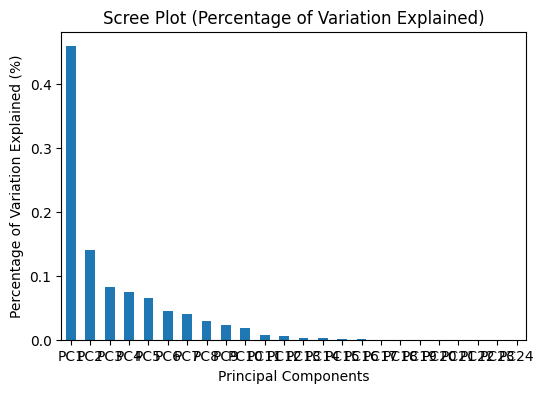

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


# PCA on data to see importance of features
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Perform PCA
pca = PCA()
principal_components = pca.fit_transform(X_scaled)

# PCA results
# Loadings / Eigenvectors for each PC (i.e. unit vector for each PC's direction)
components = pca.components_
print(f"Eigenvectors for each PC: \n{components}\n")

# PC Scores (i.e. distance from origin to each point's projection on each PC)
p_components = principal_components
print(f"Principal Component Scores: \n{p_components}\n")

# Eigenvalues for each PC (i.e. variation captured by each PC)
explained_variance = pca.explained_variance_
print(f"Eigenvalues: \n{explained_variance}\n")

# Proportion of total variation explained by each PC
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Proportion of Total Variation: \n{explained_variance_ratio}\n")

# Cumulative variation
cumulative_variance = np.cumsum(explained_variance_ratio) * 100
print(f"Cumulative Variation: \n{cumulative_variance}\n")

# Create a DataFrame for Scree Plot
explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance_ratio))],
    'Explained Variance Ratio': explained_variance_ratio
})

# Plot the Scree Plot using Seaborn
explained_variance_df.plot(
    x='Principal Component',
   y='Explained Variance Ratio',
    kind='bar',
    legend=False,
    figsize=(6,4))
plt.title('Scree Plot (Percentage of Variation Explained)')
plt.ylabel('Percentage of Variation Explained (%)')
plt.xlabel('Principal Components')
plt.xticks(rotation=0)
plt.show()


In [16]:
# finding relative importance of each variable using PCA
def create_importance_dataframe(pca, df): # create dataframe of eigenvectors for all the PCs

    # Change pcs components ndarray to a dataframe
    importance_df  = pd.DataFrame(pca.components_)

    # Assign columns
    importance_df.columns  = df.columns

    # Change to absolute values
    importance_df = importance_df.apply(np.abs)

    # Transpose
    importance_df = importance_df.transpose()

    # Change column names
    num_pcs = importance_df.shape[1]
    new_columns = [f'PC{i}' for i in range(1, num_pcs + 1)]
    importance_df.columns = new_columns

    # Return importance df
    return importance_df

# Call function to create importance df
# NOTE: Assuming 'pca' and 'X_train' are available.
importance_df = create_importance_dataframe(pca, X_train)

# modify dataframe to show importance of feature in entire dataset
# NOTE: It is assumed 'explained_variance' holds the explained variance ratio (pca.explained_variance_ratio_).
for i in range(len(explained_variance)):
    importance_df[importance_df.columns[i]] = importance_df[importance_df.columns[i]] * explained_variance[i]

# sum for each variable, normalize to 100%, and sort in descending order
final_importance_series = importance_df.transpose().sum()
final_importance_series = (final_importance_series / final_importance_series.sum()) * 100
final_importance_series = final_importance_series.sort_values(ascending=False)


# The final_importance_series now contains the relative importance (%) of each feature
print("Variable Relative Importance (Sorted Descending, %):")
print(final_importance_series)

Variable Relative Importance (Sorted Descending, %):
item_zscore_mean      5.160813e+00
user_std_mean         5.158539e+00
global_zscore_std     5.158539e+00
global_zscore_mean    5.054875e+00
user_mean_mean        5.054875e+00
item_zscore_std       5.001402e+00
item_skew_std         4.968885e+00
item_count_mean       4.905517e+00
item_min_std          4.884135e+00
item_std_std          4.873794e+00
item_min_mean         4.855853e+00
item_count_std        4.764812e+00
item_std_mean         4.692733e+00
item_skew_mean        4.690398e+00
item_mean_mean        4.689553e+00
user_skew_mean        4.652982e+00
item_mean_std         4.590344e+00
user_min_mean         4.535215e+00
user_max_mean         3.601666e+00
user_count_mean       3.497880e+00
user_zscore_std       3.480276e+00
user_zscore_mean      1.726913e+00
item_max_mean         2.257748e-18
item_max_std          1.617971e-31
dtype: float64


Linear Regression

In [17]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import mean_absolute_error
import pandas as pd

def linear_regression_cv(X_train, y_train, X_test, y_test, cv=5):
    """
    Perform linear regression with cross-validation and scaling.

    Parameters:
    X_train : array-like, training features
    y_train : array-like, training target
    X_test : array-like, testing features
    y_test : array-like, testing target
    cv : int, number of cross-validation folds (default=5)

    Returns:
    dict with model, CV results, train MAE, and test MAE
    """

    # Create pipeline: Scaling -> Linear Regression
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('linear_reg', LinearRegression())
    ])

    print("Performing Linear Regression with Cross-Validation and Scaling")
    print(f"Cross-validation folds: {cv}\n")

    # Perform cross-validation
    print("Running cross-validation on training data...")
    cv_results = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring='neg_mean_absolute_error',
        return_train_score=True
    )

    # Extract CV scores
    cv_mae_scores = -cv_results['test_score']  # Convert to positive MAE
    train_mae_scores = -cv_results['train_score']

    # Calculate statistics
    mean_cv_mae = cv_mae_scores.mean()
    std_cv_mae = cv_mae_scores.std()
    mean_train_mae = train_mae_scores.mean()

    print("\n" + "="*70)
    print("CROSS-VALIDATION RESULTS")
    print("="*70)
    print(f"\nMean CV MAE: {mean_cv_mae:.4f}")
    print(f"Std CV MAE: {std_cv_mae:.4f}")
    print(f"Mean Train MAE: {mean_train_mae:.4f}")

    print(f"\nFold-by-fold CV MAE:")
    for fold, mae in enumerate(cv_mae_scores, 1):
        print(f"  Fold {fold}: {mae:.4f}")

    # Train final model on full training set
    print("\n" + "="*70)
    print("Training final model on full training set...")
    pipeline.fit(X_train, y_train)

    # Evaluate on training set
    y_train_pred = pipeline.predict(X_train)
    train_mae = mean_absolute_error(y_train, y_train_pred)

    # Evaluate on test set
    y_test_pred = pipeline.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    print("\n" + "="*70)
    print("FINAL MODEL EVALUATION")
    print("="*70)
    print(f"\nCross-Validation MAE: {mean_cv_mae:.4f} ± {std_cv_mae:.4f}")
    print(f"Training MAE: {train_mae:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Difference (Test - Train): {test_mae - train_mae:.4f}")

    if test_mae - train_mae > 0.5:
        print("\n⚠️ Warning: Large gap between train and test MAE (possible overfitting)")
    elif test_mae - train_mae < -0.1:
        print("\n⚠️ Warning: Test MAE is better than train MAE (check data)")
    else:
        print("\n✓ Model generalization looks good")

    print("\n" + "="*70)

    return {
        'model': pipeline,
        'mean_cv_mae': mean_cv_mae,
        'std_cv_mae': std_cv_mae,
        'mean_train_mae': mean_train_mae,
        'cv_scores': cv_mae_scores,
        'train_scores': train_mae_scores,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred,
        'cv_results': cv_results
    }

In [18]:
results = linear_regression_cv(X_train, y_train, X_test, y_test, cv=5)
model = results['model']
mean_cv_mae = results['mean_cv_mae']
test_mae = results['test_mae']
train_MAE = results['train_mae']
print(mean_cv_mae)
print(f"Test MAE: {test_mae:.4f}")
print(f"Train MAE: {train_MAE:.4f}")
print(f"Difference (Test - Train): {test_mae - train_MAE:.4f}")

Performing Linear Regression with Cross-Validation and Scaling
Cross-validation folds: 5

Running cross-validation on training data...

CROSS-VALIDATION RESULTS

Mean CV MAE: 0.1258
Std CV MAE: 0.0098
Mean Train MAE: 0.1194

Fold-by-fold CV MAE:
  Fold 1: 0.1247
  Fold 2: 0.1157
  Fold 3: 0.1181
  Fold 4: 0.1267
  Fold 5: 0.1435

Training final model on full training set...

FINAL MODEL EVALUATION

Cross-Validation MAE: 0.1258 ± 0.0098
Training MAE: 0.1202
Test MAE: 0.1203
Difference (Test - Train): 0.0002

✓ Model generalization looks good

0.12575505648400234
Test MAE: 0.1203
Train MAE: 0.1202
Difference (Test - Train): 0.0002


Polynomial Regression with ridge



In [19]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import pandas as pd

def polynomial_ridge_regression_grid_search(X_train, y_train, max_degree=10, cv=5):
    """
    Perform grid search with cross-validation for polynomial regression with Ridge.
    Model selection is based ONLY on training data with cross-validation.

    Parameters:
    X_train : array-like, training features
    y_train : array-like, training target
    max_degree : int, maximum polynomial degree to test (default=10)
    cv : int, number of cross-validation folds (default=5)

    Returns:
    dict with best model, best degree, best alpha, and results
    """

    # Create a pipeline: Scaling -> Polynomial Features -> Ridge Regression
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly_features', PolynomialFeatures()),
        ('ridge_reg', Ridge())
    ])

    # Define parameter grid for polynomial degree and Ridge alpha
    degrees = list(range(1, max_degree + 1))
    alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

    param_grid = {
        'poly_features__degree': degrees,
        'ridge_reg__alpha': alphas
    }

    # Calculate total fits for progress tracking
    num_degrees = len(degrees)
    num_alphas = len(alphas)
    total_combinations = num_degrees * num_alphas
    total_fits = total_combinations * cv

    print("Performing grid search with cross-validation on training data only...")
    print(f"Polynomial degrees: {num_degrees} (1 to {max_degree})")
    print(f"Ridge alpha values: {num_alphas} {alphas}")
    print(f"Cross-validation folds: {cv}")
    print(f"Total parameter combinations: {total_combinations}")
    print(f"Total model fits: {total_fits}\n")

    # Grid search with cross-validation using MAE
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=cv,
        scoring='neg_mean_absolute_error',
        n_jobs=1,  # Set to 1 for progress tracking
        verbose=2  # Verbose level 1 shows progress
    )

    # Fit the grid search
    print("Starting grid search...\n")
    grid_search.fit(X_train, y_train)

    # Extract results
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df['degree'] = results_df['param_poly_features__degree']
    results_df['alpha'] = results_df['param_ridge_reg__alpha']
    results_df['mean_mae'] = -results_df['mean_test_score']
    results_df['std_mae'] = results_df['std_test_score']

    # Get best model and parameters
    best_degree = grid_search.best_params_['poly_features__degree']
    best_alpha = grid_search.best_params_['ridge_reg__alpha']
    best_model = grid_search.best_estimator_
    best_cv_mae = -grid_search.best_score_

    # Print results
    print("\n" + "="*70)
    print("GRID SEARCH RESULTS (Based on Cross-Validation)")
    print("="*70)
    print(f"\nBest polynomial degree: {best_degree}")
    print(f"Best Ridge alpha: {best_alpha}")
    print(f"Best cross-validation MAE: {best_cv_mae:.4f}")

    print("\nTop 10 combinations ranked by cross-validation MAE:")
    display_results = results_df[['degree', 'alpha', 'mean_mae', 'std_mae']].sort_values('mean_mae').head(10)
    print(display_results.to_string(index=False))

    print("\n" + "="*70)

    return {
        'best_model': best_model,
        'best_degree': best_degree,
        'best_alpha': best_alpha,
        'best_cv_mae': best_cv_mae,
        'results_df': results_df,
        'grid_search': grid_search
    }

In [20]:
results = polynomial_ridge_regression_grid_search(X_train, y_train, max_degree=4, cv=5)
ridge_best_model = results['best_model']
best_degree = results['best_degree']
best_cv_mae = results['best_cv_mae']
results_df = results['results_df']

Performing grid search with cross-validation on training data only...
Polynomial degrees: 4 (1 to 4)
Ridge alpha values: 7 [0.001, 0.01, 0.1, 1, 10, 100, 1000]
Cross-validation folds: 5
Total parameter combinations: 28
Total model fits: 140

Starting grid search...

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV] END ....poly_features__degree=1, ridge_reg__alpha=0.001; total time=   0.0s
[CV] END ....poly_features__degree=1, ridge_reg__alpha=0.001; total time=   0.0s
[CV] END ....poly_features__degree=1, ridge_reg__alpha=0.001; total time=   0.0s
[CV] END ....poly_features__degree=1, ridge_reg__alpha=0.001; total time=   0.0s
[CV] END ....poly_features__degree=1, ridge_reg__alpha=0.001; total time=   0.0s
[CV] END .....poly_features__degree=1, ridge_reg__alpha=0.01; total time=   0.0s
[CV] END .....poly_features__degree=1, ridge_reg__alpha=0.01; total time=   0.0s
[CV] END .....poly_features__degree=1, ridge_reg__alpha=0.01; total time=   0.0s
[CV] END .....poly_feat

In [21]:
# grid search auto scale and retrains over whole training set and comes up with best_model

# ============ Make predictions ============
print("Making predictions on training and test data...")
y_train_pred = ridge_best_model.predict(X_train)
y_test_pred = ridge_best_model.predict(X_test)
print("Done!\n")

# ============ Calculate MAE ============
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# ============ Print results ============
print("="*70)
print("FINAL MODEL EVALUATION")
print("="*70)
print(f"\nCross-Validation MAE: {best_cv_mae:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Difference (Test - Train): {test_mae - train_mae:.4f}")

# Check for overfitting/underfitting
if test_mae - train_mae > 0.5:
    print("\n⚠️ Warning: Large gap between train and test MAE (possible overfitting)")
elif test_mae - train_mae < -0.1:
    print("\n⚠️ Warning: Test MAE is better than train MAE (check data)")
else:
    print("\n✓ Model generalization looks good")

Making predictions on training and test data...
Done!

FINAL MODEL EVALUATION

Cross-Validation MAE: 0.1004
Training MAE: 0.0794
Test MAE: 0.1007
Difference (Test - Train): 0.0213

✓ Model generalization looks good


Polynomial Regression with lasso



In [22]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import pandas as pd

def polynomial_lasso_regression_grid_search(X_train, y_train, max_degree=10, cv=5):
    """
    Perform grid search with cross-validation for polynomial regression with Lasso.
    Model selection is based ONLY on training data with cross-validation.

    Parameters:
    X_train : array-like, training features
    y_train : array-like, training target
    max_degree : int, maximum polynomial degree to test (default=10)
    cv : int, number of cross-validation folds (default=5)

    Returns:
    dict with best model, best degree, best alpha, and results
    """

    # Create a pipeline: Scaling -> Polynomial Features -> Lasso Regression
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly_features', PolynomialFeatures()),
        ('lasso_reg', Lasso(max_iter=10000, tol=0.01, warm_start=True))  # Increased max_iter for convergence
    ])

    # Define parameter grid for polynomial degree and Lasso alpha
    degrees = list(range(1, max_degree + 1))
    alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

    param_grid = {
        'poly_features__degree': degrees,
        'lasso_reg__alpha': alphas
    }

    # Calculate total fits for progress tracking
    num_degrees = len(degrees)
    num_alphas = len(alphas)
    total_combinations = num_degrees * num_alphas
    total_fits = total_combinations * cv

    print("Performing grid search with cross-validation on training data only...")
    print(f"Polynomial degrees: {num_degrees} (1 to {max_degree})")
    print(f"Lasso alpha values: {num_alphas} {alphas}")
    print(f"Cross-validation folds: {cv}")
    print(f"Total parameter combinations: {total_combinations}")
    print(f"Total model fits: {total_fits}\n")

    # Grid search with cross-validation using MAE
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=cv,
        scoring='neg_mean_absolute_error',
        n_jobs=1,  # Set to 1 for progress tracking
        verbose=2  # Verbose level 1 shows progress
    )

    # Fit the grid search
    print("Starting grid search...\n")
    grid_search.fit(X_train, y_train)

    # Extract results
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df['degree'] = results_df['param_poly_features__degree']
    results_df['alpha'] = results_df['param_lasso_reg__alpha']
    results_df['mean_mae'] = -results_df['mean_test_score']
    results_df['std_mae'] = results_df['std_test_score']

    # Get best model and parameters
    best_degree = grid_search.best_params_['poly_features__degree']
    best_alpha = grid_search.best_params_['lasso_reg__alpha']
    best_model = grid_search.best_estimator_
    best_cv_mae = -grid_search.best_score_

    # Print results
    print("\n" + "="*70)
    print("GRID SEARCH RESULTS (Based on Cross-Validation)")
    print("="*70)
    print(f"\nBest polynomial degree: {best_degree}")
    print(f"Best Lasso alpha: {best_alpha}")
    print(f"Best cross-validation MAE: {best_cv_mae:.4f}")

    print("\nTop 10 combinations ranked by cross-validation MAE:")
    display_results = results_df[['degree', 'alpha', 'mean_mae', 'std_mae']].sort_values('mean_mae').head(10)
    print(display_results.to_string(index=False))

    print("\n" + "="*70)

    return {
        'best_model': best_model,
        'best_degree': best_degree,
        'best_alpha': best_alpha,
        'best_cv_mae': best_cv_mae,
        'results_df': results_df,
        'grid_search': grid_search
    }


#
# # ONLY AFTER selecting the model, evaluate on test set:
# y_test_pred = best_model.predict(X_test)
# test_mae = mean_absolute_error(y_test, y_test_pred)
# print(f"Test set MAE: {test_mae:.4f}")

In [23]:
results = polynomial_lasso_regression_grid_search(X_train, y_train, max_degree=3, cv=5)
lasso_best_model = results['best_model']
best_degree = results['best_degree']
best_alpha = results['best_alpha']
best_cv_mae = results['best_cv_mae']
results_df = results['results_df']

Performing grid search with cross-validation on training data only...
Polynomial degrees: 3 (1 to 3)
Lasso alpha values: 7 [0.001, 0.01, 0.1, 1, 10, 100, 1000]
Cross-validation folds: 5
Total parameter combinations: 21
Total model fits: 105

Starting grid search...

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] END ....lasso_reg__alpha=0.001, poly_features__degree=1; total time=   0.0s
[CV] END ....lasso_reg__alpha=0.001, poly_features__degree=1; total time=   0.0s
[CV] END ....lasso_reg__alpha=0.001, poly_features__degree=1; total time=   0.0s
[CV] END ....lasso_reg__alpha=0.001, poly_features__degree=1; total time=   0.0s
[CV] END ....lasso_reg__alpha=0.001, poly_features__degree=1; total time=   0.0s
[CV] END ....lasso_reg__alpha=0.001, poly_features__degree=2; total time=   0.0s
[CV] END ....lasso_reg__alpha=0.001, poly_features__degree=2; total time=   0.0s
[CV] END ....lasso_reg__alpha=0.001, poly_features__degree=2; total time=   0.0s
[CV] END ....lasso_reg_

In [24]:
# grid search auto scale and retrains over whole training set and comes up with best_model

# ============ Make predictions ============
print("Making predictions on training and test data...")
y_train_pred = lasso_best_model.predict(X_train)
y_test_pred = lasso_best_model.predict(X_test)
print("Done!\n")

# ============ Calculate MAE ============
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# ============ Print results ============
print("="*70)
print("FINAL MODEL EVALUATION")
print("="*70)
print(f"\nCross-Validation MAE: {best_cv_mae:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Difference (Test - Train): {test_mae - train_mae:.4f}")

# Check for overfitting/underfitting
if test_mae - train_mae > 0.5:
    print("\n⚠️ Warning: Large gap between train and test MAE (possible overfitting)")
elif test_mae - train_mae < -0.1:
    print("\n⚠️ Warning: Test MAE is better than train MAE (check data)")
else:
    print("\n✓ Model generalization looks good")

Making predictions on training and test data...
Done!

FINAL MODEL EVALUATION

Cross-Validation MAE: 0.0945
Training MAE: 0.0589
Test MAE: 0.0925
Difference (Test - Train): 0.0336

✓ Model generalization looks good


Polynomial Regression with elastic net



In [25]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import pandas as pd

def polynomial_elastic_regression_grid_search(X_train, y_train, max_degree=10, cv=5):
    """
    Perform grid search with cross-validation for polynomial regression with ElasticNet.
    Model selection is based ONLY on training data with cross-validation.

    Parameters:
    X_train : array-like, training features
    y_train : array-like, training target
    max_degree : int, maximum polynomial degree to test (default=10)
    cv : int, number of cross-validation folds (default=5)

    Returns:
    dict with best model, best degree, best alpha, best l1_ratio, and results
    """

    # Create a pipeline: Scaling -> Polynomial Features -> ElasticNet Regression
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly_features', PolynomialFeatures()),
        ('elasticnet_reg', ElasticNet(max_iter=10000, tol=0.01, warm_start=True))
    ])

    # Define parameter grid for polynomial degree, ElasticNet alpha, and l1_ratio
    degrees = list(range(1, max_degree + 1))
    alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    l1_ratios = [0.25, 0.5, 0.75]  # 0=Ridge, 1=Lasso, 0-1=ElasticNet

    param_grid = {
        'poly_features__degree': degrees,
        'elasticnet_reg__alpha': alphas,
        'elasticnet_reg__l1_ratio': l1_ratios
    }

    # Calculate total fits for progress tracking
    num_degrees = len(degrees)
    num_alphas = len(alphas)
    num_l1_ratios = len(l1_ratios)
    total_combinations = num_degrees * num_alphas * num_l1_ratios
    total_fits = total_combinations * cv

    print("Performing grid search with cross-validation on training data only...")
    print(f"Polynomial degrees: {num_degrees} (1 to {max_degree})")
    print(f"ElasticNet alpha values: {num_alphas} {alphas}")
    print(f"ElasticNet l1_ratio values: {num_l1_ratios} {l1_ratios}")
    print(f"Cross-validation folds: {cv}")
    print(f"Total parameter combinations: {total_combinations}")
    print(f"Total model fits: {total_fits}\n")

    # Grid search with cross-validation using MAE
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=cv,
        scoring='neg_mean_absolute_error',
        n_jobs=1,  # Set to 1 for progress tracking
        verbose=2  # Verbose level 1 shows progress
    )

    # Fit the grid search
    print("Starting grid search...\n")
    grid_search.fit(X_train, y_train)

    # Extract results
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df['degree'] = results_df['param_poly_features__degree']
    results_df['alpha'] = results_df['param_elasticnet_reg__alpha']
    results_df['l1_ratio'] = results_df['param_elasticnet_reg__l1_ratio']
    results_df['mean_mae'] = -results_df['mean_test_score']
    results_df['std_mae'] = results_df['std_test_score']

    # Get best model and parameters
    best_degree = grid_search.best_params_['poly_features__degree']
    best_alpha = grid_search.best_params_['elasticnet_reg__alpha']
    best_l1_ratio = grid_search.best_params_['elasticnet_reg__l1_ratio']
    best_model = grid_search.best_estimator_
    best_cv_mae = -grid_search.best_score_

    # Print results
    print("\n" + "="*70)
    print("GRID SEARCH RESULTS (Based on Cross-Validation)")
    print("="*70)
    print(f"\nBest polynomial degree: {best_degree}")
    print(f"Best ElasticNet alpha: {best_alpha}")
    print(f"Best ElasticNet l1_ratio: {best_l1_ratio}")
    print(f"Best cross-validation MAE: {best_cv_mae:.4f}")

    print("\nTop 10 combinations ranked by cross-validation MAE:")
    display_results = results_df[['degree', 'alpha', 'l1_ratio', 'mean_mae', 'std_mae']].sort_values('mean_mae').head(10)
    print(display_results.to_string(index=False))

    print("\n" + "="*70)

    return {
        'best_model': best_model,
        'best_degree': best_degree,
        'best_alpha': best_alpha,
        'best_l1_ratio': best_l1_ratio,
        'best_cv_mae': best_cv_mae,
        'results_df': results_df,
        'grid_search': grid_search
    }

In [26]:
results = polynomial_elastic_regression_grid_search(X_train, y_train, max_degree=3, cv=5)
elastic_best_model = results['best_model']
best_degree = results['best_degree']
best_alpha = results['best_alpha']
best_l1_ratio = results['best_l1_ratio']
best_cv_mae = results['best_cv_mae']
results_df = results['results_df']

Performing grid search with cross-validation on training data only...
Polynomial degrees: 3 (1 to 3)
ElasticNet alpha values: 7 [0.001, 0.01, 0.1, 1, 10, 100, 1000]
ElasticNet l1_ratio values: 3 [0.25, 0.5, 0.75]
Cross-validation folds: 5
Total parameter combinations: 63
Total model fits: 315

Starting grid search...

Fitting 5 folds for each of 63 candidates, totalling 315 fits
[CV] END elasticnet_reg__alpha=0.001, elasticnet_reg__l1_ratio=0.25, poly_features__degree=1; total time=   0.0s
[CV] END elasticnet_reg__alpha=0.001, elasticnet_reg__l1_ratio=0.25, poly_features__degree=1; total time=   0.0s
[CV] END elasticnet_reg__alpha=0.001, elasticnet_reg__l1_ratio=0.25, poly_features__degree=1; total time=   0.0s
[CV] END elasticnet_reg__alpha=0.001, elasticnet_reg__l1_ratio=0.25, poly_features__degree=1; total time=   0.0s
[CV] END elasticnet_reg__alpha=0.001, elasticnet_reg__l1_ratio=0.25, poly_features__degree=1; total time=   0.0s
[CV] END elasticnet_reg__alpha=0.001, elasticnet_reg_

In [27]:
# grid search auto scale and retrains over whole training set and comes up with best_model

# ============ Make predictions ============
print("Making predictions on training and test data...")
y_train_pred = elastic_best_model.predict(X_train)
y_test_pred = elastic_best_model.predict(X_test)
print("Done!\n")

# ============ Calculate MAE ============
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# ============ Print results ============
print("="*70)
print("FINAL MODEL EVALUATION")
print("="*70)
print(f"\nCross-Validation MAE: {best_cv_mae:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Difference (Test - Train): {test_mae - train_mae:.4f}")

# Check for overfitting/underfitting
if test_mae - train_mae > 0.5:
    print("\n⚠️ Warning: Large gap between train and test MAE (possible overfitting)")
elif test_mae - train_mae < -0.1:
    print("\n⚠️ Warning: Test MAE is better than train MAE (check data)")
else:
    print("\n✓ Model generalization looks good")

Making predictions on training and test data...
Done!

FINAL MODEL EVALUATION

Cross-Validation MAE: 0.0939
Training MAE: 0.0709
Test MAE: 0.0957
Difference (Test - Train): 0.0247

✓ Model generalization looks good


We basically see that for polynomial regression with various forms of regularisation techniques, they all perform similar to one another, hence we need to look to other methods to possibly improve the MAE. Next we try random forest regression.

Random Forest Regression

In [28]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import pandas as pd

import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import pandas as pd

def random_forest_grid_search(X_train, y_train, cv=5):
    """
    Perform grid search with cross-validation for Random Forest regression.
    Model selection is based ONLY on training data with cross-validation.
    Tunes only max_features while keeping other parameters fixed.

    Parameters:
    X_train : array-like, training features
    y_train : array-like, training target
    cv : int, number of cross-validation folds (default=5)

    Returns:
    dict with best model, best parameters, and results
    """

    # Create Random Forest model with fixed parameters
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        min_samples_leaf=1,
        random_state=42
    )

    # Define parameter grid - only tuning max_features
    param_grid = {
        'max_features': list(range(1, 24))
    }

    # Calculate total fits for progress tracking
    num_max_features = len(param_grid['max_features'])
    total_combinations = num_max_features
    total_fits = total_combinations * cv

    print("Performing grid search with cross-validation on training data only...")
    print(f"n_estimators: 100 (fixed)")
    print(f"max_depth: 20 (fixed)")
    print(f"min_samples_leaf: 1 (fixed)")
    print(f"max_features: {num_max_features} {param_grid['max_features']}")
    print(f"Cross-validation folds: {cv}")
    print(f"Total parameter combinations: {total_combinations}")
    print(f"Total model fits: {total_fits}\n")

    # Grid search with cross-validation using MAE
    grid_search = GridSearchCV(
        rf_model,
        param_grid,
        cv=cv,
        scoring='neg_mean_absolute_error',
        n_jobs=1,  # Use all cores for speed
        verbose=2
    )

    # Fit the grid search
    print("Starting grid search...\n")
    grid_search.fit(X_train, y_train)

    # Extract results
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df['max_features'] = results_df['param_max_features']
    results_df['mean_mae'] = -results_df['mean_test_score']
    results_df['std_mae'] = results_df['std_test_score']

    # Get best model and parameters
    best_max_features = grid_search.best_params_['max_features']
    best_model = grid_search.best_estimator_
    best_cv_mae = -grid_search.best_score_

    # Print results
    print("\n" + "="*70)
    print("GRID SEARCH RESULTS (Based on Cross-Validation)")
    print("="*70)
    print(f"\nBest max_features: {best_max_features}")
    print(f"Best cross-validation MAE: {best_cv_mae:.4f}")

    print("\nAll max_features ranked by cross-validation MAE:")
    display_results = results_df[['max_features', 'mean_mae', 'std_mae']].sort_values('mean_mae')
    print(display_results.to_string(index=False))

    print("\n" + "="*70)

    return {
        'best_model': best_model,
        'best_max_features': best_max_features,
        'best_cv_mae': best_cv_mae,
        'results_df': results_df,
        'grid_search': grid_search
    }

In [29]:
results = random_forest_grid_search(X_train, y_train, cv=5)
rf_best_model = results['best_model']
best_max_features = results['best_max_features']
best_cv_mae = results['best_cv_mae']
results_df = results['results_df']

Performing grid search with cross-validation on training data only...
n_estimators: 100 (fixed)
max_depth: 20 (fixed)
min_samples_leaf: 1 (fixed)
max_features: 23 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Cross-validation folds: 5
Total parameter combinations: 23
Total model fits: 115

Starting grid search...

Fitting 5 folds for each of 23 candidates, totalling 115 fits
[CV] END .....................................max_features=1; total time=   0.2s
[CV] END .....................................max_features=1; total time=   0.2s
[CV] END .....................................max_features=1; total time=   0.2s
[CV] END .....................................max_features=1; total time=   0.2s
[CV] END .....................................max_features=1; total time=   0.2s
[CV] END .....................................max_features=2; total time=   0.2s
[CV] END .....................................max_features=2; total time=   0.2s
[CV] END ........

In [30]:
# ============ Make predictions ============
print("Making predictions on training and test data...")
y_train_pred = rf_best_model.predict(X_train)
y_test_pred = rf_best_model.predict(X_test)
print("Done!\n")

# ============ Calculate MAE ============
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# ============ Print results ============
print("="*70)
print("FINAL MODEL EVALUATION")
print("="*70)
print(f"\nCross-Validation MAE: {best_cv_mae:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Difference (Test - Train): {test_mae - train_mae:.4f}")

# Check for overfitting/underfitting
if test_mae - train_mae > 0.5:
    print("\n⚠️ Warning: Large gap between train and test MAE (possible overfitting)")
elif test_mae - train_mae < -0.1:
    print("\n⚠️ Warning: Test MAE is better than train MAE (check data)")
else:
    print("\n✓ Model generalization looks good")

print("\n" + "="*70)

Making predictions on training and test data...
Done!

FINAL MODEL EVALUATION

Cross-Validation MAE: 0.0832
Training MAE: 0.0304
Test MAE: 0.0808
Difference (Test - Train): 0.0503

✓ Model generalization looks good



Adaptive Boost

In [31]:
import numpy as np
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import pandas as pd

def adaboost_grid_search(X_train, y_train, cv=5):
    """
    Perform grid search with cross-validation for AdaBoost regression.
    Model selection is based ONLY on training data with cross-validation.

    Parameters:
    X_train : array-like, training features
    y_train : array-like, training target
    cv : int, number of cross-validation folds (default=5)

    Returns:
    dict with best model, best parameters, and results
    """

    # Create AdaBoost model with DecisionTree as base estimator
    ada_model = AdaBoostRegressor(
        estimator=DecisionTreeRegressor(max_depth=5),
        random_state=42
    )

    # Define parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.001, 0.001, 0.01, 0.1, 1.0],
        'loss': ['linear', 'square', 'exponential']
    }

    # Calculate total fits for progress tracking
    num_n_estimators = len(param_grid['n_estimators'])
    num_learning_rate = len(param_grid['learning_rate'])
    num_loss = len(param_grid['loss'])
    total_combinations = num_n_estimators * num_learning_rate * num_loss
    total_fits = total_combinations * cv

    print("Performing grid search with cross-validation on training data only...")
    print(f"n_estimators: {num_n_estimators} {param_grid['n_estimators']}")
    print(f"learning_rate: {num_learning_rate} {param_grid['learning_rate']}")
    print(f"loss: {num_loss} {param_grid['loss']}")
    print(f"Cross-validation folds: {cv}")
    print(f"Total parameter combinations: {total_combinations}")
    print(f"Total model fits: {total_fits}\n")

    # Grid search with cross-validation using MAE
    grid_search = GridSearchCV(
        ada_model,
        param_grid,
        cv=cv,
        scoring='neg_mean_absolute_error',
        n_jobs=1,
        verbose=2
    )

    # Fit the grid search
    print("Starting grid search...\n")
    grid_search.fit(X_train, y_train)

    # Extract results
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df['n_estimators'] = results_df['param_n_estimators']
    results_df['learning_rate'] = results_df['param_learning_rate']
    results_df['loss'] = results_df['param_loss']
    results_df['mean_mae'] = -results_df['mean_test_score']
    results_df['std_mae'] = results_df['std_test_score']

    # Get best model and parameters
    best_n_estimators = grid_search.best_params_['n_estimators']
    best_learning_rate = grid_search.best_params_['learning_rate']
    best_loss = grid_search.best_params_['loss']
    best_model = grid_search.best_estimator_
    best_cv_mae = -grid_search.best_score_

    # Print results
    print("\n" + "="*70)
    print("GRID SEARCH RESULTS (Based on Cross-Validation)")
    print("="*70)
    print(f"\nBest n_estimators: {best_n_estimators}")
    print(f"Best learning_rate: {best_learning_rate}")
    print(f"Best loss: {best_loss}")
    print(f"Best cross-validation MAE: {best_cv_mae:.4f}")

    print("\nTop 10 combinations ranked by cross-validation MAE:")
    display_results = results_df[['n_estimators', 'learning_rate', 'loss', 'mean_mae', 'std_mae']].sort_values('mean_mae').head(10)
    print(display_results.to_string(index=False))

    print("\n" + "="*70)

    return {
        'best_model': best_model,
        'best_n_estimators': best_n_estimators,
        'best_learning_rate': best_learning_rate,
        'best_loss': best_loss,
        'best_cv_mae': best_cv_mae,
        'results_df': results_df,
        'grid_search': grid_search
    }

In [32]:
results = adaboost_grid_search(X_train, y_train, cv=5)
ada_best_model = results['best_model']
best_n_estimators = results['best_n_estimators']
best_learning_rate = results['best_learning_rate']
best_loss = results['best_loss']
best_cv_mae = results['best_cv_mae']

Performing grid search with cross-validation on training data only...
n_estimators: 4 [50, 100, 200, 300]
learning_rate: 5 [0.001, 0.001, 0.01, 0.1, 1.0]
loss: 3 ['linear', 'square', 'exponential']
Cross-validation folds: 5
Total parameter combinations: 60
Total model fits: 300

Starting grid search...

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END ..learning_rate=0.001, loss=linear, n_estimators=50; total time=   0.4s
[CV] END ..learning_rate=0.001, loss=linear, n_estimators=50; total time=   0.3s
[CV] END ..learning_rate=0.001, loss=linear, n_estimators=50; total time=   0.3s
[CV] END ..learning_rate=0.001, loss=linear, n_estimators=50; total time=   0.6s
[CV] END ..learning_rate=0.001, loss=linear, n_estimators=50; total time=   1.0s
[CV] END .learning_rate=0.001, loss=linear, n_estimators=100; total time=   1.7s
[CV] END .learning_rate=0.001, loss=linear, n_estimators=100; total time=   2.0s
[CV] END .learning_rate=0.001, loss=linear, n_estimators=100; tota

In [33]:
# ============ Make predictions ============
print("Making predictions on training and test data...")
y_train_pred = ada_best_model.predict(X_train)
y_test_pred = ada_best_model.predict(X_test)
print("Done!\n")

# ============ Calculate MAE ============
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# ============ Print results ============
print("="*70)
print("FINAL MODEL EVALUATION")
print("="*70)
print(f"\nCross-Validation MAE: {best_cv_mae:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Difference (Test - Train): {test_mae - train_mae:.4f}")

# Check for overfitting/underfitting
if test_mae - train_mae > 0.5:
    print("\n⚠️ Warning: Large gap between train and test MAE (possible overfitting)")
elif test_mae - train_mae < -0.1:
    print("\n⚠️ Warning: Test MAE is better than train MAE (check data)")
else:
    print("\n✓ Model generalization looks good")

print("\n" + "="*70)

Making predictions on training and test data...
Done!

FINAL MODEL EVALUATION

Cross-Validation MAE: 0.0916
Training MAE: 0.0601
Test MAE: 0.0849
Difference (Test - Train): 0.0248

✓ Model generalization looks good



Light Gradient Boosting Machine (LGBM)

In [ ]:
# install LGBM
# pip install lightgbm

In [34]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import pandas as pd

def lgbm_grid_search(X_train, y_train, cv=5):
    """
    Perform grid search with cross-validation for LightGBM regression.
    Model selection is based ONLY on training data with cross-validation.

    Parameters:
    X_train : array-like, training features
    y_train : array-like, training target
    cv : int, number of cross-validation folds (default=5)

    Returns:
    dict with best model, best parameters, and results
    """

    # Create LightGBM model
    lgbm_model = lgb.LGBMRegressor(
        random_state=42,
        verbose=0,
        n_jobs=-1
    )

    # Define parameter grid: ADDING 'reg_alpha'
    param_grid = {
        'n_estimators': [50, 100, 500],
        'learning_rate': [0.001, 0.01, 0.1, 1],
        'max_depth': [5, 10, 15, 20, 24]
    }

    # Calculate total fits for progress tracking
    num_n_estimators = len(param_grid['n_estimators'])
    num_learning_rate = len(param_grid['learning_rate'])
    num_max_depth = len(param_grid['max_depth'])
    total_combinations = (num_n_estimators * num_learning_rate * num_max_depth)
    total_fits = total_combinations * cv

    print("Performing grid search with cross-validation on training data only...")
    print(f"n_estimators: {num_n_estimators} {param_grid['n_estimators']}")
    print(f"learning_rate: {num_learning_rate} {param_grid['learning_rate']}")
    print(f"max_depth: {num_max_depth} {param_grid['max_depth']}")
    print(f"Cross-validation folds: {cv}")
    print(f"Total parameter combinations: {total_combinations}")
    print(f"Total model fits: {total_fits}\n")

    # Grid search with cross-validation using MAE
    grid_search = GridSearchCV(
        lgbm_model,
        param_grid,
        cv=cv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=0
    )

    # Fit the grid search
    print("Starting grid search...\n")
    grid_search.fit(X_train, y_train)

    # Extract results
    results_df = pd.DataFrame(grid_search.cv_results_)
    # Extract existing params
    results_df['n_estimators'] = results_df['param_n_estimators']
    results_df['learning_rate'] = results_df['param_learning_rate']
    results_df['max_depth'] = results_df['param_max_depth']
    results_df['mean_mae'] = -results_df['mean_test_score']
    results_df['std_mae'] = results_df['std_test_score']

    # Get best model and parameters
    best_n_estimators = grid_search.best_params_['n_estimators']
    best_learning_rate = grid_search.best_params_['learning_rate']
    best_max_depth = grid_search.best_params_['max_depth']
    best_model = grid_search.best_estimator_
    best_cv_mae = -grid_search.best_score_

    # Print results
    print("\n" + "="*70)
    print("GRID SEARCH RESULTS (Based on Cross-Validation)")
    print("="*70)
    print(f"\nBest n_estimators: {best_n_estimators}")
    print(f"Best learning_rate: {best_learning_rate}")
    print(f"Best max_depth: {best_max_depth}")
    print(f"Best cross-validation MAE: {best_cv_mae:.4f}")

    print("\nTop 10 combinations ranked by cross-validation MAE:")
    display_results = results_df[['n_estimators', 'learning_rate',
                                  'max_depth', 'mean_mae', 'std_mae']].sort_values('mean_mae').head(10)
    print(display_results.to_string(index=False))

    print("\n" + "="*70)

    return {
        'best_model': best_model,
        'best_n_estimators': best_n_estimators,
        'best_learning_rate': best_learning_rate,
        'best_max_depth': best_max_depth,
        'best_cv_mae': best_cv_mae,
        'results_df': results_df,
        'grid_search': grid_search
    }

In [35]:
results = lgbm_grid_search(X_train, y_train, cv=5)
lgbm_best_model = results['best_model']
best_n_estimators = results['best_n_estimators']
best_learning_rate = results['best_learning_rate']
best_max_depth = results['best_max_depth']
best_cv_mae = results['best_cv_mae']

Performing grid search with cross-validation on training data only...
n_estimators: 3 [50, 100, 500]
learning_rate: 4 [0.001, 0.01, 0.1, 1]
max_depth: 5 [5, 10, 15, 20, 24]
Cross-validation folds: 5
Total parameter combinations: 60
Total model fits: 300

Starting grid search...

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [36]:
# ============ Make predictions ============
print("Making predictions on training and test data...")
y_train_pred = lgbm_best_model.predict(X_train)
y_test_pred = lgbm_best_model.predict(X_test)
print("Done!\n")

# ============ Calculate MAE ============
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# ============ Print results ============
print("="*70)
print("FINAL MODEL EVALUATION")
print("="*70)
print(f"\nCross-Validation MAE: {best_cv_mae:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Difference (Test - Train): {test_mae - train_mae:.4f}")

# Check for overfitting/underfitting
if test_mae - train_mae > 0.5:
    print("\n⚠️ Warning: Large gap between train and test MAE (possible overfitting)")
elif test_mae - train_mae < -0.1:
    print("\n⚠️ Warning: Test MAE is better than train MAE (check data)")
else:
    print("\n✓ Model generalization looks good")

print("\n" + "="*70)

Making predictions on training and test data...
Done!

FINAL MODEL EVALUATION

Cross-Validation MAE: 0.0817
Training MAE: 0.0009
Test MAE: 0.0793
Difference (Test - Train): 0.0784

✓ Model generalization looks good



Extreme Gradient Boost (XGB)

In [37]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import pandas as pd

def xgb_grid_search(X_train, y_train, cv=5):
    """
    Perform grid search with cross-validation for XGBoost regression.
    Model selection is based ONLY on training data with cross-validation.

    Parameters:
    X_train : array-like, training features
    y_train : array-like, training target
    cv : int, number of cross-validation folds (default=5)

    Returns:
    dict with best model, best parameters, and results
    """

    # --- Change 2: Create XGBoost model ---
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',  # Standard objective for regression
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric='mae',
        verbosity=0 # Use verbosity=0 instead of verbose=0
    )

    # --- Change 3: Define parameter grid (Using XGBoost names) ---
    param_grid = {
        'n_estimators': [50, 100, 500],
        'learning_rate': [0.001, 0.01, 0.1, 1],
        'max_depth': [5, 10, 15, 20, 24],
    }

    # Calculate total fits for progress tracking
    num_n_estimators = len(param_grid['n_estimators'])
    num_learning_rate = len(param_grid['learning_rate'])
    num_max_depth = len(param_grid['max_depth'])
    total_combinations = (num_n_estimators * num_learning_rate * num_max_depth)
    total_fits = total_combinations * cv

    print("Performing grid search with cross-validation on training data only...")
    print(f"n_estimators: {num_n_estimators} {param_grid['n_estimators']}")
    print(f"learning_rate: {num_learning_rate} {param_grid['learning_rate']}")
    print(f"max_depth: {num_max_depth} {param_grid['max_depth']}")
    print(f"Cross-validation folds: {cv}")
    print(f"Total parameter combinations: {total_combinations}")
    print(f"Total model fits: {total_fits}\n")

    # Grid search with cross-validation using MAE
    grid_search = GridSearchCV(
        xgb_model,
        param_grid,
        cv=cv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1 # Changed to 1 to show progress, as verbosity=0 hides all output
    )

    # Fit the grid search
    print("Starting grid search...\n")
    grid_search.fit(X_train, y_train)

    # Extract results
    results_df = pd.DataFrame(grid_search.cv_results_)
    # Extract existing params
    results_df['n_estimators'] = results_df['param_n_estimators']
    results_df['learning_rate'] = results_df['param_learning_rate']
    results_df['max_depth'] = results_df['param_max_depth']
    results_df['mean_mae'] = -results_df['mean_test_score']
    results_df['std_mae'] = results_df['std_test_score']

    # Get best model and parameters
    best_n_estimators = grid_search.best_params_['n_estimators']
    best_learning_rate = grid_search.best_params_['learning_rate']
    best_max_depth = grid_search.best_params_['max_depth']
    best_model = grid_search.best_estimator_
    best_cv_mae = -grid_search.best_score_

    # Print results
    print("\n" + "="*70)
    print("GRID SEARCH RESULTS (Based on Cross-Validation)")
    print("="*70)
    print(f"\nBest n_estimators: {best_n_estimators}")
    print(f"Best learning_rate: {best_learning_rate}")
    print(f"Best max_depth: {best_max_depth}")
    print(f"Best cross-validation MAE: {best_cv_mae:.4f}")

    print("\nTop 10 combinations ranked by cross-validation MAE:")
    display_results = results_df[['n_estimators', 'learning_rate',
                                  'max_depth', 'mean_mae', 'std_mae']].sort_values('mean_mae').head(10)
    print(display_results.to_string(index=False))

    print("\n" + "="*70)

    return {
        'best_model': best_model,
        'best_n_estimators': best_n_estimators,
        'best_learning_rate': best_learning_rate,
        'best_max_depth': best_max_depth,
        'best_cv_mae': best_cv_mae,
        'results_df': results_df,
        'grid_search': grid_search
    }

In [38]:
results = xgb_grid_search(X_train, y_train, cv=5)
xgb_best_model = results['best_model']
best_n_estimators = results['best_n_estimators']
best_learning_rate = results['best_learning_rate']
best_max_depth = results['best_max_depth']
best_cv_mae = results['best_cv_mae']

Performing grid search with cross-validation on training data only...
n_estimators: 3 [50, 100, 500]
learning_rate: 4 [0.001, 0.01, 0.1, 1]
max_depth: 5 [5, 10, 15, 20, 24]
Cross-validation folds: 5
Total parameter combinations: 60
Total model fits: 300

Starting grid search...

Fitting 5 folds for each of 60 candidates, totalling 300 fits

GRID SEARCH RESULTS (Based on Cross-Validation)

Best n_estimators: 500
Best learning_rate: 0.1
Best max_depth: 5
Best cross-validation MAE: 0.0803

Top 10 combinations ranked by cross-validation MAE:
 n_estimators  learning_rate  max_depth  mean_mae  std_mae
          500           0.10          5  0.080318 0.006560
          100           0.10          5  0.081196 0.006352
          500           0.01          5  0.082355 0.006937
           50           0.10          5  0.082684 0.006781
          500           0.01         10  0.087400 0.009422
          500           0.10         10  0.087594 0.009181
          100           0.10         10  0.

In [39]:
# ============ Make predictions ============
print("Making predictions on training and test data...")
y_train_pred = xgb_best_model.predict(X_train)
y_test_pred = xgb_best_model.predict(X_test)
print("Done!\n")

# ============ Calculate MAE ============
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# ============ Print results ============
print("="*70)
print("FINAL MODEL EVALUATION")
print("="*70)
print(f"\nCross-Validation MAE: {best_cv_mae:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Difference (Test - Train): {test_mae - train_mae:.4f}")

# Check for overfitting/underfitting
if test_mae - train_mae > 0.5:
    print("\n⚠️ Warning: Large gap between train and test MAE (possible overfitting)")
elif test_mae - train_mae < -0.1:
    print("\n⚠️ Warning: Test MAE is better than train MAE (check data)")
else:
    print("\n✓ Model generalization looks good")

print("\n" + "="*70)

Making predictions on training and test data...
Done!

FINAL MODEL EVALUATION

Cross-Validation MAE: 0.0803
Training MAE: 0.0011
Test MAE: 0.0784
Difference (Test - Train): 0.0772

✓ Model generalization looks good



Neural Networks

In [40]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras import models, layers # Use models and layers as requested
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor # CRITICAL: Use Regressor for MAE loss
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error # Use MAE for final evaluation

def create_model(units, learning_rate=0.01):
    """
    Keras model builder for CONSTRAINED REGRESSION (using sigmoid activation
    to force output between 0 and 1).
    """
    model = models.Sequential([
        layers.Input(shape=(24,)),
        layers.Dense(units=units, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile model using MAE loss
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="mae",
        metrics=['mae']
    )
    return model

# Define Early Stopping Callback
# Monitor 'loss' (validation loss) to stop overfitting
early_stop = EarlyStopping(
    monitor='loss', # Monitor validation loss during CV folds
    patience=50, # Stop if validation loss doesn't improve for 50 epochs
    restore_best_weights=True,
    verbose=0
)

# --- 2. Pipeline and Grid Search Setup ---

# Create a pipeline to standardize the data and apply KerasRegressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    # KerasRegressor is correct for continuous targets
    ('keras_model', KerasRegressor(
        model=create_model,
        callbacks=[early_stop],
        batch_size=64,
        epochs=100,
        random_state=42,
        verbose=0
    ))
])

# Define hyperparameter grid
param_grid = {
    'keras_model__model__learning_rate': [0.01, 0.1], # Changed learning rate values
    'keras_model__model__units': [2,3,4,5,6,7,8,9,10,11,12],
    'keras_model__batch_size': [64, 128, 256],
}

# --- Fix: Define cv before it's used ---
cv = 5

# Set up GridSearchCV
grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring='neg_mean_absolute_error', # GridSearchCV maximizes score
    cv=cv, # Example CV folds
    n_jobs=1
)

# --- 3. Run and Evaluate ---

# Calculate the total number of fits including all parameter combinations and CV folds
total_fits_calculated = len(param_grid['keras_model__model__learning_rate']) * len(param_grid['keras_model__model__units']) * len(param_grid['keras_model__batch_size']) * cv

print(f"Starting Grid Search with {total_fits_calculated} total fits ({cv} CV folds)...")

y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

# Run the grid search
grid_search = grid.fit(X_train, y_train_reshaped)

# Get optimal parameters
best_learning_rate = grid_search.best_params_['keras_model__model__learning_rate']
best_nodes = grid_search.best_params_['keras_model__model__units']
best_batch_size = grid_search.best_params_['keras_model__batch_size']
best_cv_neg_mae = grid_search.best_score_
best_cv_mae = -best_cv_neg_mae # Convert negative score back to positive MAE

print("\n" + "="*50)
print("GRID SEARCH RESULTS")
print("="*50)
print(f"Best learning_rate: {best_learning_rate}")
print(f"Best nodes (units): {best_nodes}")
print(f"Best batch_size: {best_batch_size}")
print(f"Best cross-validated MAE: {best_cv_mae:.8f}")

# Retrieve best model (the entire pipeline)
neural_network_best_pipeline = grid_search.best_estimator_

Starting Grid Search with 330 total fits (5 CV folds)...



GRID SEARCH RESULTS
Best learning_rate: 0.1
Best nodes (units): 7
Best batch_size: 64
Best cross-validated MAE: 0.08154238


In [41]:
# Create a DataFrame from the results
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Select only the most relevant columns for easy comparison
# We convert the score back to positive MAE for easier interpretation
cv_results_df['mean_cv_mae'] = -cv_results_df['mean_test_score']

# Columns to display: Hyperparameters and the resulting MAE
display_columns = [
    'param_keras_model__model__learning_rate',
    'param_keras_model__model__units',
    'param_keras_model__batch_size',
    'mean_cv_mae',
    'std_test_score', # Shows the standard deviation across the 5 folds
    'rank_test_score' # 1 is the best
]

# Sort by the MAE and print
cv_results_sorted = cv_results_df[display_columns].sort_values(by='mean_cv_mae', ascending=True)

# Print the sorted results, showing all rows due to the set_option call
print(cv_results_sorted.to_string())
print("="*50)

    param_keras_model__model__learning_rate  param_keras_model__model__units  param_keras_model__batch_size  mean_cv_mae  std_test_score  rank_test_score
16                                     0.10                                7                             64     0.081542        0.008886                1
36                                     0.10                                5                            128     0.082177        0.010538                2
40                                     0.10                                9                            128     0.082278        0.008095                3
38                                     0.10                                7                            128     0.083325        0.013432                4
35                                     0.10                                4                            128     0.083528        0.010725                5
39                                     0.10                                8

In [42]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras import models, layers # Use models and layers as requested
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor # CRITICAL: Use Regressor for MAE loss
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error # Use MAE for final evaluation

def create_model(units1, units2, learning_rate=0.01):
    """
    Keras model builder for CONSTRAINED REGRESSION (using sigmoid activation
    to force output between 0 and 1).
    Now includes two hidden layers with different unit sizes.
    """
    model = models.Sequential([
        layers.Input(shape=(24,)),
        layers.Dense(units=units1, activation='relu'),
        layers.Dense(units=units2, activation='relu'),  # Second hidden layer
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile model using MAE loss
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="mae",
        metrics=['mae']
    )
    return model

# Define Early Stopping Callback
# Monitor 'loss' (validation loss) to stop overfitting
early_stop = EarlyStopping(
    monitor='loss', # Monitor validation loss during CV folds
    patience=50, # Stop if validation loss doesn't improve for 50 epochs
    restore_best_weights=True,
    verbose=0
)

# --- 2. Pipeline and Grid Search Setup ---

# Create a pipeline to standardize the data and apply KerasRegressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    # KerasRegressor is correct for continuous targets
    ('keras_model', KerasRegressor(
        model=create_model,
        callbacks=[early_stop],
        batch_size=64,
        epochs=100,
        random_state=42,
        verbose=0
    ))
])

# Define hyperparameter grid
param_grid = {
    'keras_model__model__learning_rate': [0.01],
    'keras_model__model__units1': [16, 32, 64],  # First hidden layer
    'keras_model__model__units2': [16, 32, 64],  # Second hidden layer
    'keras_model__batch_size': [64, 128, 256],
}

# --- Fix: Define cv before it's used ---
cv = 5

# Set up GridSearchCV
grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring='neg_mean_absolute_error', # GridSearchCV maximizes score
    cv=cv, # Example CV folds
    n_jobs=1
)

# --- 3. Run and Evaluate ---

# Calculate the total number of fits including all parameter combinations and CV folds
total_fits_calculated = len(param_grid['keras_model__model__learning_rate']) * len(param_grid['keras_model__model__units1']) * len(param_grid['keras_model__model__units2']) * len(param_grid['keras_model__batch_size']) * cv

print(f"Starting Grid Search with {total_fits_calculated} total fits ({cv} CV folds)...")

y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

# Run the grid search
grid_search = grid.fit(X_train, y_train_reshaped)

# Get optimal parameters
best_learning_rate = grid_search.best_params_['keras_model__model__learning_rate']
best_units1 = grid_search.best_params_['keras_model__model__units1']
best_units2 = grid_search.best_params_['keras_model__model__units2']
best_batch_size = grid_search.best_params_['keras_model__batch_size']
best_cv_neg_mae = grid_search.best_score_
best_cv_mae = -best_cv_neg_mae # Convert negative score back to positive MAE

print("\n" + "="*50)
print("GRID SEARCH RESULTS")
print("="*50)
print(f"Best learning_rate: {best_learning_rate}")
print(f"Best units (layer 1): {best_units1}")
print(f"Best units (layer 2): {best_units2}")
print(f"Best batch_size: {best_batch_size}")
print(f"Best cross-validated MAE: {best_cv_mae:.8f}")

# Retrieve best model (the entire pipeline)
neural_network_best_pipeline = grid_search.best_estimator_

Starting Grid Search with 135 total fits (5 CV folds)...

GRID SEARCH RESULTS
Best learning_rate: 0.01
Best units (layer 1): 16
Best units (layer 2): 16
Best batch_size: 64
Best cross-validated MAE: 0.07551464


In [43]:
# Create a DataFrame from the results
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Select only the most relevant columns for easy comparison
# We convert the score back to positive MAE for easier interpretation
cv_results_df['mean_cv_mae'] = -cv_results_df['mean_test_score']

# Columns to display: Hyperparameters and the resulting MAE
display_columns = [
    'param_keras_model__model__learning_rate',
    'param_keras_model__model__units1',
    'param_keras_model__model__units2',
    'param_keras_model__batch_size',
    'mean_cv_mae',
    'std_test_score', # Shows the standard deviation across the 5 folds
    'rank_test_score' # 1 is the best
]

# Sort by the MAE and print
cv_results_sorted = cv_results_df[display_columns].sort_values(by='mean_cv_mae', ascending=True)

# Print the sorted results, showing all rows due to the set_option call
print(cv_results_sorted.to_string())
print("="*50)

    param_keras_model__model__learning_rate  param_keras_model__model__units1  param_keras_model__model__units2  param_keras_model__batch_size  mean_cv_mae  std_test_score  rank_test_score
0                                      0.01                                16                                16                             64     0.075515        0.001822                1
5                                      0.01                                32                                64                             64     0.076476        0.009010                2
7                                      0.01                                64                                32                             64     0.077228        0.006192                3
6                                      0.01                                64                                16                             64     0.077891        0.007130                4
11                                     0.01            

In [44]:
# Use best model to predict on the validation set
y_train_pred = neural_network_best_pipeline.predict(X_train)
y_test_pred = neural_network_best_pipeline.predict(X_test)

# Evaluate using Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"\nFinal Test Set Evaluation:")
print(f"MAE on Training Set: {train_mae:.8f}")
print(f"MAE on Test Set (using best model): {test_mae:.8f}")
print("="*50)


Final Test Set Evaluation:
MAE on Training Set: 0.04091862
MAE on Test Set (using best model): 0.07971519


# Classification

In [45]:
print(y_cat)

    user     label  anomtype
0    561  0.383316         1
1    202  0.925028         2
2    205  0.380860         2
3    424  0.255181         1
4    284  0.055162         2
5    667  0.558745         0
6    730  0.311928         1
7    469  0.233492         2
8    199  0.165112         1
9    699  0.261752         2
10   231  0.951103         0
11    26  0.558222         0
12   786  0.549116         0
13   849  0.301816         1
14   459  0.739300         0


In [46]:
from scipy.stats import skew
from IPython.display import display
import pandas as pd

# --- Compute basic user-level features ---
def basic_features(df):
    feats = (
        df.groupby('user')['rating']
        .agg(
            n_ratings='count',
            mean='mean',
            std='std',
            skew=lambda x: skew(x, bias=False) if len(x) > 2 else 0
        )
        .reset_index()
    )
    feats['n_unique_items'] = df.groupby('user')['item'].nunique().values
    feats['dup_rate'] = 1 - feats['n_unique_items'] / feats['n_ratings']
    return feats

# --- Compute features ---
feats = basic_features(X)

# --- Merge only with users present in y_cat ---
merged = (
    feats
    .merge(y, on='user', how='left')
    .merge(y_cat, on='user', how='inner', suffixes=('_y', '_ycat'))
)

display(
    merged
      .sort_values(['anomtype', 'user'])
      .style
      .set_table_styles([{'selector': 'th, td', 'props': [('white-space', 'nowrap')]}])
      .hide(axis='index')
)


user,n_ratings,mean,std,skew,n_unique_items,dup_rate,label_y,label_ycat,anomtype
26,244,2.922131,1.185510,-0.490847,244,0.000000,0.558222,0.558222,0
231,358,2.455307,1.113685,0.033444,358,0.000000,0.951103,0.951103,0
459,230,2.782609,1.216930,-0.177129,230,0.000000,0.739300,0.739300,0
667,444,2.709459,1.011804,-0.352036,444,0.000000,0.558745,0.558745,0
786,287,2.630662,1.032429,-0.287200,287,0.000000,0.549116,0.549116,0
199,211,3.388626,1.104391,-0.603176,210,0.004739,0.165112,0.165112,1
424,200,3.330000,0.868835,-0.370751,200,0.000000,0.255181,0.255181,1
561,205,3.439024,1.085754,-0.479909,201,0.019512,0.383316,0.383316,1
730,234,2.923077,0.850689,-0.485062,231,0.012821,0.311928,0.311928,1
849,212,3.547170,0.833335,-0.671797,207,0.023585,0.301816,0.301816,1


From a first glance, it seems very clear that users with no duplicates tend to be anomtype 0

It also seems like anomtype 2 users tend to have a higher amount of ratings than anontype 1.

However it is too early to make any assumptions, as this is only 15 users.